In [1]:
from langgraph.graph import StateGraph, START, END

from langgraph.checkpoint.redis import RedisSaver
from states import *
from prompts import *
import dotenv
dotenv.load_dotenv()


from langchain_core.messages import SystemMessage, HumanMessage
from parsers import parse_directory_files
from langchain_openai import ChatOpenAI


In [2]:
# from langchain_openai import ChatOpenAI

# model = ChatOpenAI(model="o4-mini", reasoning_effort="high")
# # state = State(data_path="/Users/omar/work/andrea/data")

# files = parse_directory_files("/Users/omar/work/andrea/data_temp")




In [3]:
# files = parse_directory_files("/Users/omar/work/andrea/data")

# for file in files:
#     print(file['file_name'])
#     print(file['content'])
#     print("--------------------------------")

In [4]:
import pickle

# # write pickle

# with open('files.pkl', 'wb') as f:
#     pickle.dump(files, f)

with open('../files.pkl', 'rb') as f:
    files = pickle.load(f)
files

[{'file_name': 'employee_payroll.png',
  'content': "ACME Inc.\n\nPayroll Register\n\nDisplay Retro Results: No\nHide Zero Gross and Zero Net Results: No\nPeriod: 7/20/2024 - 08/02/2024 (Non-Exempt BI-Weekly (WDPAY))\nPay Run Groups and/or Pay Group Details: Non-Exempt Hourly - Regular\n\nRow 1:\nGroup Name: US Hourly CA (2nd Check) (Pay Group Detail)\nPayroll Result: 7/20/2024 - 8/2/2024 (Non-Exempt BI-Weekly (WDPAY1)) (Period)\nWorker: \nGross Pay: 0\nAdd to Gross - PCG - Class Report Field: 0\nFederal Taxable Don't W/H - PCG - Class Report Field: 0\nFederal Taxable W/H - PCG - Class Report Field: 0\nNet Pay: 0\nResult Type - Description: 0\nStatus: 0\n\nRow 2:\nEmp 1: 08/02/2024 (Regular) In Progress\nGross Pay: $1,191.42\nAdd to Gross - PCG - Class Report Field: $1,191.42\nFederal Taxable Don't W/H - PCG - Class Report Field: $0.00\nFederal Taxable W/H - PCG - Class Report Field: $1,191.42\nNet Pay: $984.42\nResult Type - Description: On Demand Payment - Replacement\nStatus: Comple

In [5]:
import pprint
i = 4
pprint.pprint(files[i]['file_name'])

pprint.pprint(files[i]['content'])

'bank_info.png'
('Row 1: 08/07  174,393.91  WT Fed#05238 Deutsche Bank Trus /Drw/Bnf=ADP '
 'Client Trust Sr# 080759437002008 Trnf248007046188 Rfb# 1700404973')


In [6]:
# model = ChatOpenAI(model="gpt-4.1-mini", ) #o4-mini #reasoning_effort="high"
# model = ChatOpenAI(model="o4-mini", reasoning_effort="high")
model = ChatOpenAI(model="gpt-4.1")

def relevance_to_SOX_and_financial_standards(state: State):
    print("--------------------------------")
    print("Relevance to SOX and financial standards")
    
    messages = [
        SystemMessage(content=RELEVANCE_TO_SOX_AND_FINANCIAL_STANDARDS_PROMPT),
        HumanMessage(content=str(state.tasks_raw))
    ]

    response = model.with_structured_output(RelevanceToSoxAndFinancialStandards).invoke(messages)
    state.relevance_to_sox_and_financial_standards = response
    print(response)
    return state


def metadata_extractor(state: State):
    print("--------------------------------")
    print("Extracting metadata")
    # files = parse_directory_files(state['data_path'])

    for file in files:

        messages = [
            SystemMessage(content=METADATA_EXTRACTOR_PROMPT),
            HumanMessage(content="File Name: " + file['file_name'] + "\nFile Content: \n" + file['content'])
        ]


        response = model.with_structured_output(DocMetadata).invoke(messages)
        state.docs_content_with_metadata.append(DocumentWithMetadata(name=file['file_name'], purpose=response.purpose, possible_use_cases=response.possible_use_cases, content=file['content']))
        print(file['file_name'], "\n", response)
    return state


def tasks_parser(state: State):
    print("--------------------------------")
    print("Parsing tasks")
    tasks = state.tasks_raw

    messages = [
        SystemMessage(content=TASK_PARSER_PROMPT),
        HumanMessage(content=tasks)
    ]

    response = model.with_structured_output(Tasks).invoke(messages)
    state.tasks_parsed = response
    print(response)
    print("length of tasks: ", len(response.tasks))
    return state
    

def document_to_task_mapper(state: State):
    print("--------------------------------")
    print("Mapping documents to tasks")
    print(state.tasks_parsed.tasks)


    for task in state.tasks_parsed.tasks:
        organized_docs = ""
        i = 1
        for doc in state.docs_content_with_metadata: 
            organized_docs += "\n\n" + str(i) + ". File Name: " + doc.name + "\nFile Purpose: " + doc.purpose + "\nFile Possible Use Cases: " + doc.possible_use_cases + "\nFile Content: \n<start document_content of " + doc.name + ">\n" + doc.content + "\n<end document_content of " + doc.name + ">\n\n"
            i += 1

        messages = [
            SystemMessage(content=DOCUMENT_TO_TASK_MAPPER_PROMPT),
            HumanMessage(content="Task: " + task + "\n\nDocuments to map: " + str(organized_docs))
        ]

        response = model.with_structured_output(DocumentToTaskMapper).invoke(messages)
        response.task = task
        state.document_to_task_mapper.append(response)
        print(task, "\n", response)


    return state


def execution_agent(state: State):
    print("--------------------------------")
    print("Executing tasks")
    print(state.document_to_task_mapper)
    
    for item in state.document_to_task_mapper:
        docs_content = ""
        i = 1
        for doc in item.docs:
            docs_content += "\n\n" + str(i) + ". File Name: " + doc.name + "\nFile Content: \n<document_content " + doc.name + ">\n" + doc.content + "\n</document_content " + doc.name + ">\n\n"
            i += 1

        messages = [
            SystemMessage(content=EXECUTION_AGENT_PROMPT),
            HumanMessage(content="Task: " + str(item.task) + "\nDocuments: \n" + docs_content)
        ]

        response = model.with_structured_output(ExecutionAgent).invoke(messages)
        state.execution_task_output.append(ExecutionAgent(task=item.task, output=response.output, pass_or_fail=response.pass_or_fail, file_name=doc.name))
        print(item.task, "\n", response)
    
    return state

def reflector(state: State):
    print("--------------------------------")
    print("Reflecting on the tasks")
    state.is_in_reflection = True


    messages = [
        SystemMessage(content=REFLECTOR_PROMPT),
        HumanMessage(content="Task: " + str(item.task) + "\n" + "Output: " + str(item.output) + "\n" + "Pass or Fail: " + str(item.pass_or_fail))
    ]

    response = model.invoke(messages)
    print(response)

    return state

def reporter(state: State):
    print("--------------------------------")
    print("Reporting results")
    print(state.execution_task_output)

    if not state.relevance_to_sox_and_financial_standards.is_relevant:
        state.reporter = "The given tasks are not relevant to SOX and financial standards, because of " + state.relevance_to_sox_and_financial_standards.reason
        print("**************************************************")
        print(state.reporter)
        print("**************************************************")
        return state

    task_report=""  
    state.reporter = ""
    for item in state.execution_task_output:
        task_report += "Task: " + str(item.task) + "\n" + "Output: " + str(item.output) + "\n" + "Pass or Fail: " + str(item.pass_or_fail) + "\n\n"

        messages = [
            SystemMessage(content=REPORTER_PROMPT),
            HumanMessage(content=task_report)
        ]

        response = model.with_structured_output(Reporter).invoke(messages)
        state.reporter += "\n\n---\n\n" + response.output + "\n\n---\n\n"


    return state
def is_relevant(state: State):

    if state.relevance_to_sox_and_financial_standards.is_relevant:
        return "continue"
    else:
        return "stop"
        
def should_continue(state: State):
    state.is_in_reflection = True
    state.task_current_iteration +=1
    if state.task_current_iteration < state.task_max_iterations:
        return 'continue'
    else:
        return 'stop'

22:17:02 langgraph.checkpoint.redis INFO   Redis client is a standalone client
22:17:02 redisvl.index.index INFO   Index already exists, not overwriting.
22:17:02 redisvl.index.index INFO   Index already exists, not overwriting.
22:17:02 redisvl.index.index INFO   Index already exists, not overwriting.


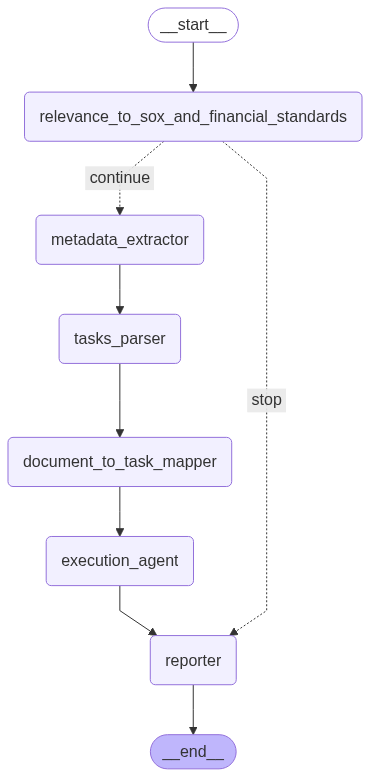

In [7]:


builder = StateGraph(State)
builder.add_node("relevance_to_sox_and_financial_standards", relevance_to_SOX_and_financial_standards)
builder.add_node("metadata_extractor", metadata_extractor)
builder.add_node("tasks_parser", tasks_parser)
builder.add_node("document_to_task_mapper", document_to_task_mapper)
builder.add_node("execution_agent", execution_agent)
builder.add_node("reporter", reporter)

builder.add_edge(START, "relevance_to_sox_and_financial_standards")
builder.add_conditional_edges("relevance_to_sox_and_financial_standards", is_relevant, {"stop": "reporter", "continue": "metadata_extractor"})
builder.add_edge("metadata_extractor", "tasks_parser")
builder.add_edge("tasks_parser", "document_to_task_mapper")
builder.add_edge("document_to_task_mapper", "execution_agent")
builder.add_edge("execution_agent", "reporter")
builder.add_edge("reporter", END)


REDIS_URI = "redis://localhost:6379/0"
with RedisSaver.from_conn_string(REDIS_URI) as checkpointer:
    checkpointer.setup()
    
    graph = builder.compile(checkpointer=checkpointer)

graph

In [8]:
tasks = """TASKS:

1. Compare ADP payroll data, bank payroll data, and settlement runs payroll data. Make sure that the numeric totals are all the same


2. Compare employee payroll data from screenshots to the employee payroll data from the CSV. Make sure that the payroll amounts in the CSV match the payroll amounts in the screenshot. 


3. Compare employee total payroll data from screenshots to the total employee payroll from the CSV. Make sure the 2 payroll amounts match. 
"""

In [9]:
graph.invoke(input={"data_path": "/Users/omar/work/andrea/data", "tasks_raw": tasks}, config={"configurable": {"thread_id": "1"}})

--------------------------------
Relevance to SOX and financial standards
22:17:04 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
is_relevant=True reason='All the tasks involve verifying payroll data accuracy and consistency across different sources. Payroll is a financially significant area subject to SOX controls, as accurate payroll processing and financial reporting are essential for compliance with SOX and other financial standards.'
--------------------------------
Extracting metadata
22:17:06 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
employee_payroll.png 
 name='employee_payroll.png' purpose='To document employee payroll results for a bi-weekly pay period, providing details such as gross pay, net pay, taxable wages, status, and result type for each worker.' possible_use_cases='Payroll processing and auditing, financial reporting, verification of payment for employees, internal HR and

{'data_path': '/Users/omar/work/andrea/data',
 'tasks_raw': 'TASKS:\n\n1. Compare ADP payroll data, bank payroll data, and settlement runs payroll data. Make sure that the numeric totals are all the same\n\n\n2. Compare employee payroll data from screenshots to the employee payroll data from the CSV. Make sure that the payroll amounts in the CSV match the payroll amounts in the screenshot. \n\n\n3. Compare employee total payroll data from screenshots to the total employee payroll from the CSV. Make sure the 2 payroll amounts match. \n',
 'docs_content_with_metadata': [DocumentWithMetadata(name='employee_payroll.png', purpose='To document employee payroll results for a bi-weekly pay period, providing details such as gross pay, net pay, taxable wages, status, and result type for each worker.', possible_use_cases='Payroll processing and auditing, financial reporting, verification of payment for employees, internal HR and finance department reconciliation, compliance documentation, and pre

In [10]:
state = graph.get_state(config={"configurable": {"thread_id": "1"}}).values

In [11]:
state.keys()

dict_keys(['data_path', 'tasks_raw', 'docs_content_with_metadata', 'tasks_parsed', 'document_to_task_mapper', 'execution_task_output', 'reflector', 'reporter', 'task_max_iterations', 'task_current_iteration', 'is_in_reflection', 'relevance_to_sox_and_financial_standards'])

In [18]:
import pprint

pprint.pprint(state['execution_task_output'][0].output)

('To compare the numeric totals for payroll in the three sources (ADP payroll, '
 'bank payroll, and settlement runs), I extracted the key payment totals as '
 'follows:\n'
 '\n'
 '1. ADP Payroll Data (adp_payroll.png):\n'
 '   - Wire Amount/Total: $174,393.91 (DR)\n'
 '\n'
 '2. Bank Payroll Data (bank_info.png):\n'
 '   - 08/07 Wire Amount: $174,393.91\n'
 '\n'
 '3. Settlement Runs Payroll Data (settlement_runs.png):\n'
 '   - Settlement Run: SR-22495\n'
 '   - Outbound Total: $174,383.91\n'
 '\n'
 '4. Payroll Register Total (Payroll reconcilation DEMO.csv):\n'
 '   - Total Settlements for 8/9/2024: $174,393.91\n'
 '   - Payroll register - Regular Run: $179,078.00\n'
 '   - Payroll register - 2nd Check Run: $121.41\n'
 '   - Total Amount per Registers: $179,199.41 (this is higher due to '
 'off-cycles, showed as a $4,805.50 variance because off cycles/missed hours '
 'are handled separately)\n'
 '\n'
 'Observations and Comparison:\n'
 '- The ADP payroll and bank payroll both show $174